In [1]:
import mdtraj as md
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import biotite
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.structure.io.xtc as xtc

In [2]:
def get_FE(file_path, pdb_name, temperatureList, save_path):

    plt.figure(figsize=(9, 6))
    rmsd_values, qs = None, None
    for temperature in temperatureList:
        top_h_path = file_path + pdb_name + "/" + pdb_name + "_CA.pdb"
        top_h = md.load(top_h_path)
        print(top_h_path)
        for i in range(1, 4):
            traj_path = file_path + pdb_name + "/" + temperature + "/ca" + str(i) + ".xtc"
            print(traj_path)
            traj = md.load(traj_path, top=top_h)

            # rmsd_value = md.rmsd(traj, top_h)
            template = strucio.load_structure(top_h_path)
            protein_mask = struc.filter_amino_acids(template)
            template = template[protein_mask]
            xtc_file = xtc.XTCFile.read(traj_path, atom_i=np.where(protein_mask)[0])
            trajectory = xtc_file.get_structure(template)
            trajectory = struc.remove_pbc(trajectory)
            trajectory, transform = struc.superimpose(trajectory[0], trajectory)
            rmsd_value = struc.rmsd(trajectory[0], trajectory)

            q = best_hummer_q(traj, top_h)
            if rmsd_values is None:
                rmsd_values = rmsd_value
                qs = q
            else:
                rmsd_values = np.append(rmsd_values, rmsd_value)
                qs = np.append(qs, q)
        print(len(rmsd_values))

    z, x, y = np.histogram2d(rmsd_values, qs, bins=25)
    extent = [x[0], x[-1], y[0], y[-1]]
    plt.contourf(np.log(z.T), 25, cmap=plt.cm.Blues, extent=extent)
    clb = plt.colorbar()
    clb.set_label('ln(count)', family='Times New Roman', weight='bold', fontsize=22)
    clb.ax.tick_params(labelsize=18)
    plt.xlabel('RMSD (Å)', family='Times New Roman', weight='bold', fontsize=22)
    plt.ylabel('Q', family='Times New Roman', weight='bold', fontsize=22)
    plt.xlim(0, 7)
    plt.ylim(0.7, 1)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(save_path + pdb_name + "_" + temperatureList[0] + ".png", format='png', dpi=600)
    plt.show()
    
def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]

    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used

    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`

    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """

    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers

    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i, j) for (i, j) in combinations(heavy, 2)
         if abs(native.topology.atom(i).residue.index - \
                native.topology.atom(j).residue.index) > 3])

    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))

    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)

    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q

C:/Users/17351/Downloads/md/TY1/TY1_CA.pdb
C:/Users/17351/Downloads/md/TY1/300k/ca1.xtc
Number of native contacts 14
C:/Users/17351/Downloads/md/TY1/300k/ca2.xtc
Number of native contacts 14
C:/Users/17351/Downloads/md/TY1/300k/ca3.xtc
Number of native contacts 14
30003
C:/Users/17351/Downloads/md/TY1/TY1_CA.pdb
C:/Users/17351/Downloads/md/TY1/350k/ca1.xtc
Number of native contacts 14
C:/Users/17351/Downloads/md/TY1/350k/ca2.xtc
Number of native contacts 14
C:/Users/17351/Downloads/md/TY1/350k/ca3.xtc
Number of native contacts 14
60006
C:/Users/17351/Downloads/md/TY1/TY1_CA.pdb
C:/Users/17351/Downloads/md/TY1/400k/ca1.xtc
Number of native contacts 14
C:/Users/17351/Downloads/md/TY1/400k/ca2.xtc
Number of native contacts 14
C:/Users/17351/Downloads/md/TY1/400k/ca3.xtc
Number of native contacts 14
90009


C:\Users\17351\AppData\Local\Temp\ipykernel_15664\850253346.py:35: RuntimeWarning: divide by zero encountered in log
  plt.contourf(np.log(z.T), 25, cmap=plt.cm.Blues, extent=extent)


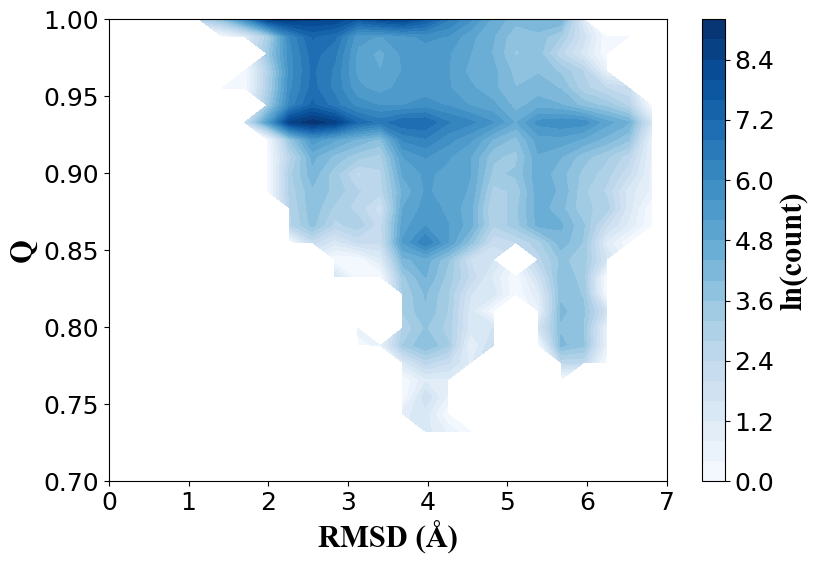

In [4]:
file_path = "C:/Users/17351/Downloads/md/"
pdb_name = "TY1"
temperatureList = ["300k", "350k", "400k"]
save_path = "C:/Users/17351/Desktop/protein_fram/G11/Figs/free_energy/"
get_FE(file_path, pdb_name, temperatureList, save_path)